In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/pool_iPSC")

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


In [0]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


In [4]:
%ls -lth scanpy_out/

total 1.1G
-rw------- 1 root root 339M May 14 23:32 pool_iPSC_wholeset_with_donors.h5ad
-rw------- 1 root root 233K May 14 23:32 pool_iPSC_wholeset_with_donors.csv
-rw------- 1 root root 165M May 14 23:22 pool_iPSC_wholeset2.h5ad
-rw------- 1 root root 113M May  4 03:49 pool_iPSC_with_donors.h5ad
-rw------- 1 root root 339M May  4 03:34 pool_iPSC_wholeset.h5ad
-rw------- 1 root root  890 Apr 21 13:32 pool_iPSC_leiden_by_donor.csv
-rw------- 1 root root 233K Apr 21 13:29 pool_iPSC_adata_with_donors.csv
-rw------- 1 root root 113M Apr 16 22:52 pool_iPSC.h5ad
-rw------- 1 root root  13K Apr 16 22:52 top_markers_pool1_neurons_hNGN2_HVG.csv


In [0]:
# load the scanpy object which has been analyzed before
adata = sc.read("scanpy_out/pool_iPSC_wholeset2.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 3381 × 18996 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

# Add my donor information from vireo_out

Note that there are unassigned cells due to the assigning ambugrity between GT19-38452 or  GT19-38451.

Next time, remove the sample of GT19-38452 from donor_vcf files before runing vireo

For the present, manually assign GT19-38452/1 back to cell barcodes

In [0]:
# input my donor information from vireo_out
%ls vireo/vireo_out/

donor_ids.tsv                  _log.txt             prob_singlet.tsv.gz
fig_GT_distance_estimated.pdf  prob_doublet.tsv.gz  summary.tsv


In [7]:
donors= pd.read_csv("vireo/vireo_out/donor_ids.tsv", '\t', index_col="cell")
donors.head(4)

,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet
cell,,,,,,
AAACCCACACAAGGTG-1,GT19-38449,1.000,1.210000e-22,264,GT19-38449,"GT19-38447,GT19-38449"
AAACCCACAGGTTCCG-1,GT19-38449,1.000,2.720000e-19,250,GT19-38449,"GT19-38448,GT19-38445"
AAACCCAGTACTGCCG-1,GT19-38449,0.995,3.010000e-03,18,GT19-38449,"GT19-38447,GT19-38449"
AAACCCAGTTATCTGG-1,GT19-38451,1.000,2.170000e-40,501,GT19-38451,"GT19-38446,GT19-38450"


Assign missing donor_id to cell barcodes

In [8]:
donors_subset = donors[["donor_id"]]
donors_subset["donor_label"]=donors["donor_id"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# only get the column of interest and add one more for match to meatadata
donors_subset.head()

,donor_id,donor_label
cell,,
AAACCCACACAAGGTG-1,GT19-38449,GT19-38449
AAACCCACAGGTTCCG-1,GT19-38449,GT19-38449
AAACCCAGTACTGCCG-1,GT19-38449,GT19-38449
AAACCCAGTTATCTGG-1,GT19-38451,GT19-38451
AAACCCATCACAACCA-1,GT19-38447,GT19-38447


# get the metadata of the donors

In [0]:
%ls ../test_vireo/modify_donor/

'Copy of 19-Cel-005 Metadata.xlsx'   test_donor_to_use.vcf.gz
 meta_7Labels.csv                    test_donor.vcf
 meta_wgs_Psomagen.7Labels.csv       test_donor.vcf.gz
 meta_wgs_Psomagen.csv               test_donor.vcf.gz.tbi
 sedfnjT29                           test_today/
 sub_UNHS_changed.vcf.gz             UNHS_to_use_7s.vcf.gz
 sub_UNHS_changed.vcf.gz.tbi         UNHS_to_use.vcf.gz
 sub_UNHS_filter.vcf.gz              UNHS.vcf.gz
 sub_UNHS.vcf.gz                     UNHS.vcf.gz.csi
 sub_UNHS.vcf.gz.csi                 UNHS.vcf.gz.tbi
 test_cell.vcf.gz


In [0]:
# retrieve the 8 donor's original labels from metadata
meta = pd.read_csv("../test_vireo/modify_donor/meta_wgs_Psomagen.7Labels.csv")

In [0]:
meta

,sample_id,donor_label
0,GT19-38445,KOLF2-ARID2-A02
1,GT19-38446,KUCG3-C1
2,GT19-38447,NCRM1-C6
3,GT19-38448,NCRM5-C5
4,GT19-38449,PGP1-C2
5,GT19-38450,LNGPI1-C1
6,GT19-38451,NN0003932-C3 or NN0004297-C1


# match donor_id to donor_label

In [9]:
# # match donor_id to donor_label
vals_to_replace = {'GT19-38445':'KOLF2-ARID2-A02', 
                   'GT19-38446':'KUCG3-C1', 
                   'GT19-38447':'NCRM1-C6',
                   'GT19-38448':'NCRM5-C5',
                   'GT19-38449':'PGP1-C2',
                   'GT19-38450':'LNGPI1-C1',
                   'GT19-38451':'NN0003932-C3 or NN0004297-C1'
                   }

donors_subset["donor_label"] = donors_subset["donor_label"].map(vals_to_replace)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
donors_subset.head()

,donor_id,donor_label
cell,,
AAACCCACACAAGGTG-1,GT19-38449,PGP1-C2
AAACCCACAGGTTCCG-1,GT19-38449,PGP1-C2
AAACCCAGTACTGCCG-1,GT19-38449,PGP1-C2
AAACCCAGTTATCTGG-1,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCATCACAACCA-1,GT19-38447,NCRM1-C6


In [10]:
adata.obs.head()

,n_genes,percent_mito,n_counts
AAACCCACACAAGGTG-1,2978,0.077939,7570.0
AAACCCACAGGTTCCG-1,2834,0.060555,7068.0
AAACCCAGTTATCTGG-1,4375,0.057387,16502.0
AAACCCATCAGAGCGA-1,3536,0.059018,10268.0
AAACCCATCCCAATAG-1,2572,0.049352,6484.0


In [12]:
# note that the row numbers of donor_subset and that of adata are not the same because adata has been filtered for doublets
print("cell numbers in donor_file are:", len(donors_subset))
print("cell numbers in adata are:", len(adata.obs))

cell numbers in donor_file are: 3458
cell numbers in adata are: 3381


# merge donor_label to adata

In [13]:
# merge two dataframes
adata.obs = adata.obs.merge(donors_subset, left_index=True, right_index=True)
adata.obs.head()

,n_genes,percent_mito,n_counts,donor_id,donor_label
AAACCCACACAAGGTG-1,2978,0.077939,7570.0,GT19-38449,PGP1-C2
AAACCCACAGGTTCCG-1,2834,0.060555,7068.0,GT19-38449,PGP1-C2
AAACCCAGTTATCTGG-1,4375,0.057387,16502.0,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCATCAGAGCGA-1,3536,0.059018,10268.0,GT19-38450,LNGPI1-C1
AAACCCATCCCAATAG-1,2572,0.049352,6484.0,GT19-38446,KUCG3-C1


In [0]:
# generate a table in which list the cell lines by Leiden-derived clusters in each experiment
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9775 entries, AAACCCAAGGCTTTCA-1 to TTTGTTGTCTTTACAC-1
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   n_genes       9775 non-null   int64   
 1   percent_mito  9775 non-null   float32 
 2   n_counts      9775 non-null   float32 
 3   leiden        9775 non-null   category
 4   donor_id      9775 non-null   category
 5   donor_label   9775 non-null   category
dtypes: category(3), float32(2), int64(1)
memory usage: 579.2+ KB


In [14]:
adata.write_h5ad("scanpy_out/pool_iPSC_wholeset_with_donors2.h5ad")

... storing 'donor_id' as categorical
... storing 'donor_label' as categorical


In [0]:
adata.obs.to_csv("scanpy_out/pool_iPSC_adata_wholeset_with_donors2.csv")

In [0]:
table = adata.obs.groupby(['donor_label'])['leiden'].agg(["count", "nunique", "unique"])

In [0]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [0]:
table

,count,nunique,unique
donor_label,,,
KOLF2-ARID2-A02,387,8,"[2, 3, 1, 4, 0, 6, 5, 8] Categories (8, object): [2, 3, 1, 4, 0, 6, 5, 8]"
KUCG3-C1,638,9,"[1, 5, 4, 3, 6, 7, 2, 0, 8] Categories (9, object): [1, 5, 4, 3, ..., 7, 2, 0, 8]"
LNGPI1-C1,295,2,"[6, 0] Categories (2, object): [6, 0]"
NCRM1-C6,1010,8,"[2, 0, 1, 7, 3, 5, 4, 8] Categories (8, object): [2, 0, 1, 7, 3, 5, 4, 8]"
NCRM5-C5,70,3,"[2, 3, 8] Categories (3, object): [2, 3, 8]"
NN0003932-C3 or NN0004297-C1,306,8,"[3, 2, 1, 7, 8, 4, 0, 5] Categories (8, object): [3, 2, 1, 7, 8, 4, 0, 5]"
PGP1-C2,481,8,"[4, 5, 3, 7, 1, 0, 8, 2] Categories (8, object): [4, 5, 3, 7, 1, 0, 8, 2]"


In [0]:
table.to_csv("scanpy_out/pool_iPSC_donor_by_leiden.csv")

In [0]:
table2 = adata.obs.groupby(['leiden'])['donor_label'].agg(["count", "nunique", "unique"])

In [0]:
table2

,count,nunique,unique
leiden,,,
0,634,6,"[NCRM1-C6, KUCG3-C1, nan, KOLF2-ARID2-A02, PGP1-C2, NN0003932-C3 or NN0004297-C1, LNGPI1-C1]"
1,490,5,"[KUCG3-C1, NCRM1-C6, KOLF2-ARID2-A02, PGP1-C2, nan, NN0003932-C3 or NN0004297-C1]"
2,452,6,"[KOLF2-ARID2-A02, NCRM1-C6, NN0003932-C3 or NN0004297-C1, NCRM5-C5, nan, KUCG3-C1, PGP1-C2]"
3,460,6,"[NN0003932-C3 or NN0004297-C1, PGP1-C2, KOLF2-ARID2-A02, NCRM1-C6, KUCG3-C1, NCRM5-C5, nan]"
4,399,5,"[PGP1-C2, KUCG3-C1, nan, NCRM1-C6, KOLF2-ARID2-A02, NN0003932-C3 or NN0004297-C1]"
5,308,5,"[PGP1-C2, KUCG3-C1, NCRM1-C6, nan, KOLF2-ARID2-A02, NN0003932-C3 or NN0004297-C1]"
6,300,3,"[LNGPI1-C1, KUCG3-C1, nan, KOLF2-ARID2-A02]"
7,118,4,"[NCRM1-C6, PGP1-C2, nan, KUCG3-C1, NN0003932-C3 or NN0004297-C1]"
8,26,6,"[NCRM1-C6, NN0003932-C3 or NN0004297-C1, KUCG3-C1, PGP1-C2, NCRM5-C5, KOLF2-ARID2-A02, nan]"


In [0]:
table2.to_csv("scanpy_out/pool_iPSC_leiden_by_donor.csv")

In [0]:
adata.write_h5ad("scanpy_out/pool_iPSC_with_donors.h5ad")

... storing 'donor_id' as categorical
... storing 'donor_label' as categorical


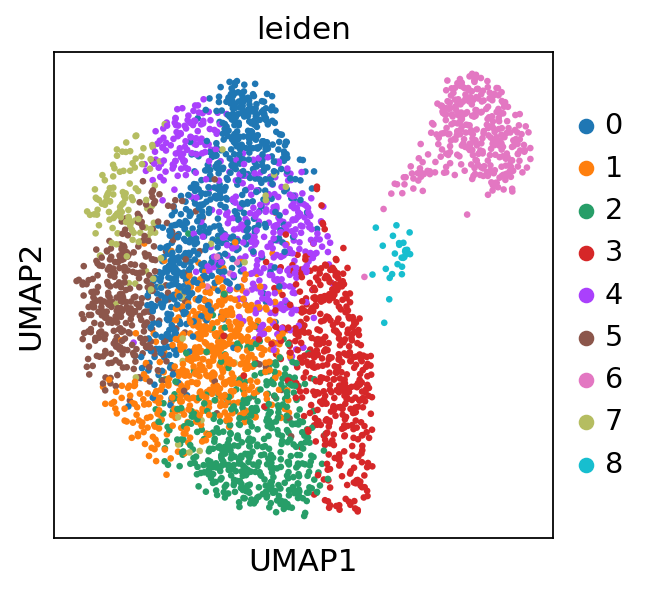

In [0]:
# skip gene "TMEM106B)"
sc.pl.umap(adata, color=['leiden'], save="pool_iPSC_clusters.pdf")

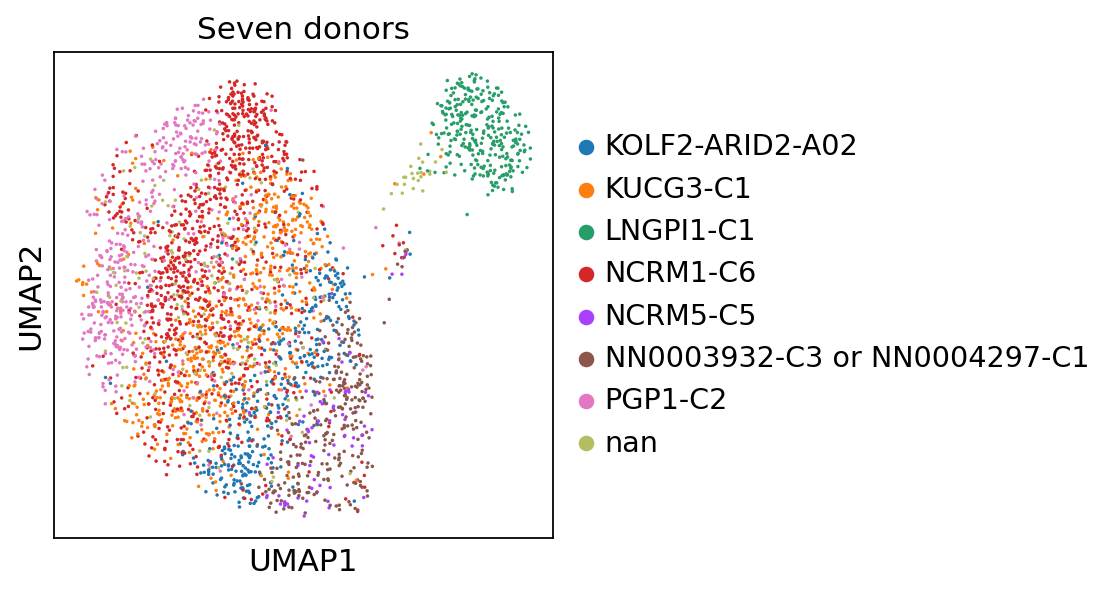

In [0]:
sc.pl.umap(adata, color=['donor_label'], title="Seven donors", size=10, save="pool_iPSC_donors.pdf")

In [0]:
labels = ['KOLF2-ARID2-A02',
 'KUCG3-C1',
 'NCRM1-C6',
 'NCRM5-C5',
 'PGP1-C2',
 'LNGPI1-C1',
 'NN0003932-C3 or NN0004297-C1', 'nan']

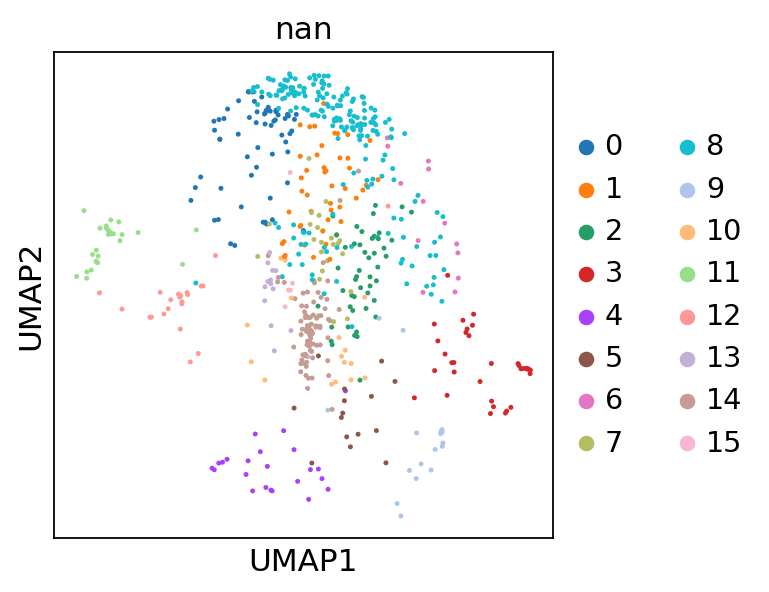

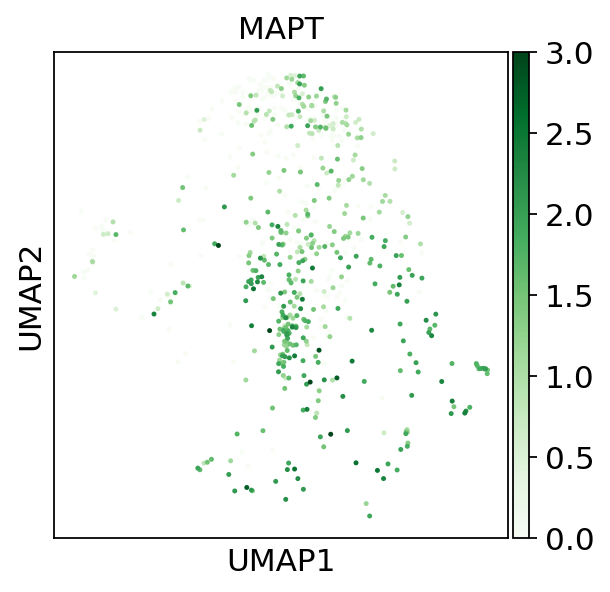

In [0]:
ax = sc.pl.umap(adata[adata.obs["donor_label"] == "nan"], color="leiden", color_map="Blues", title='nan', size=20)
sc.pl.umap(
    adata[adata.obs["donor_label"] == "nan"],
    size=20,
    color=["MAPT"],
    color_map="Greens",
    vmax=3,
    ax = ax
  )

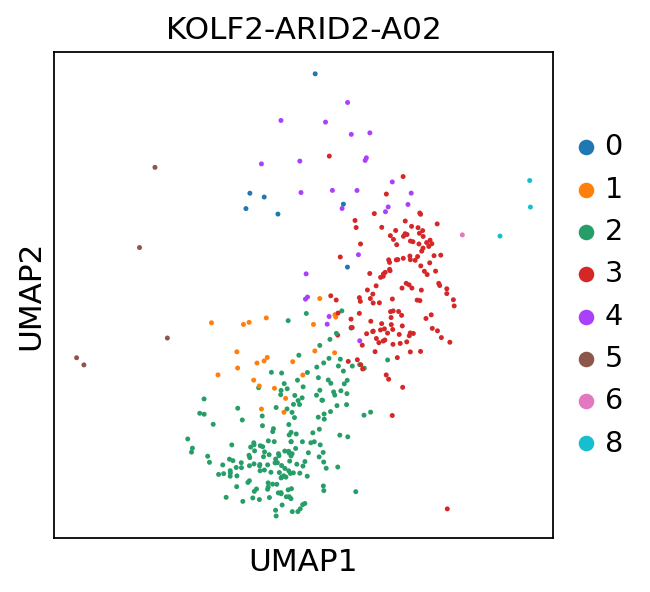

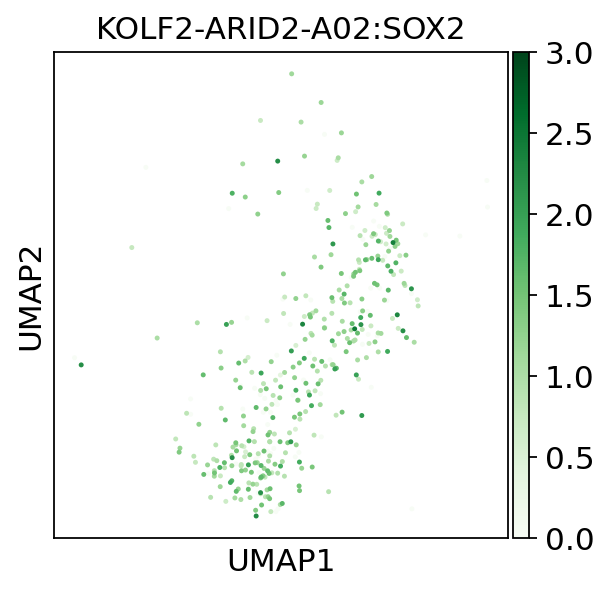

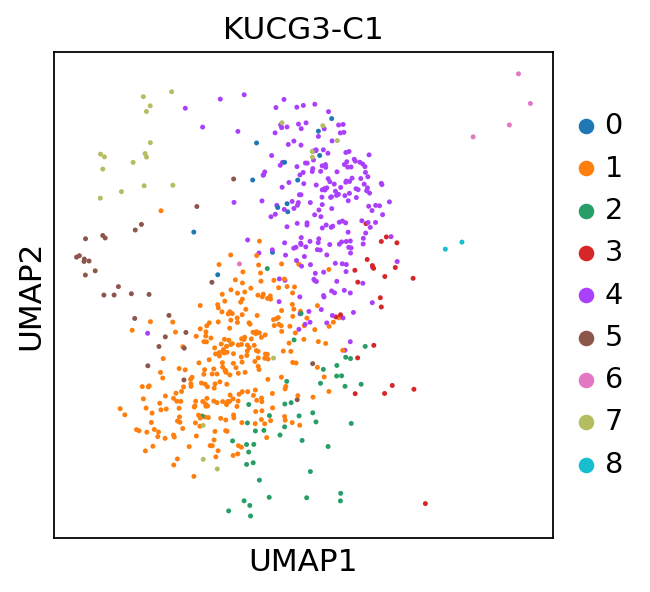

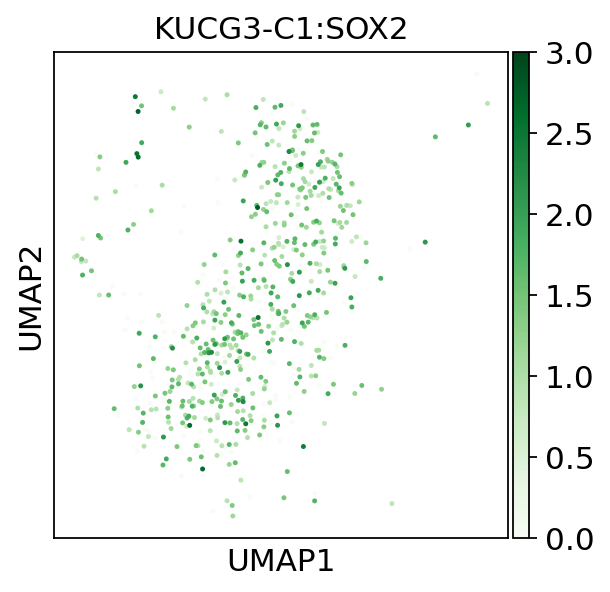

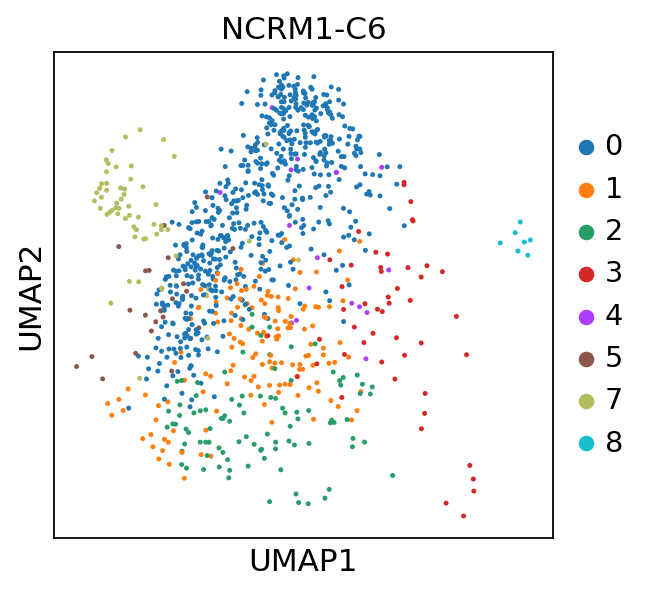

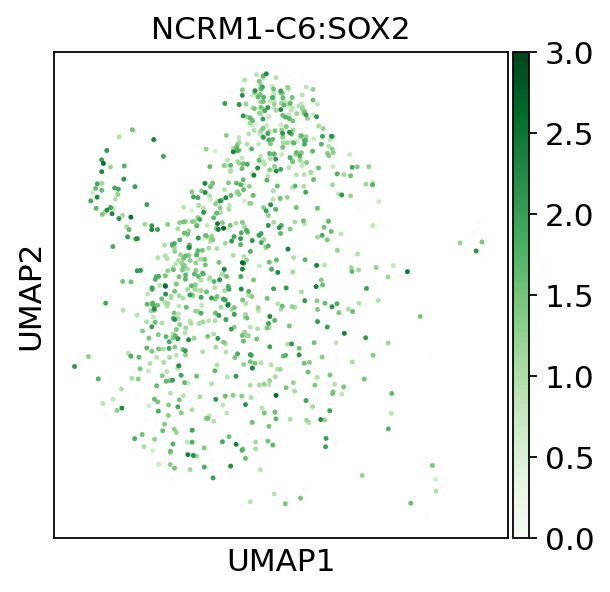

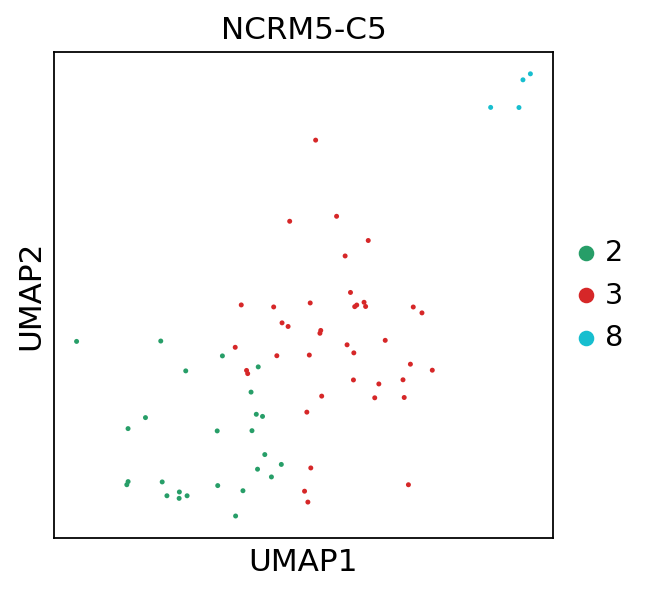

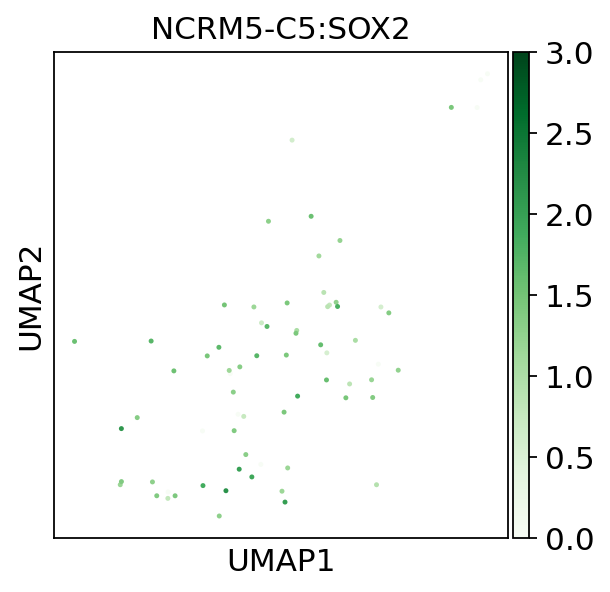

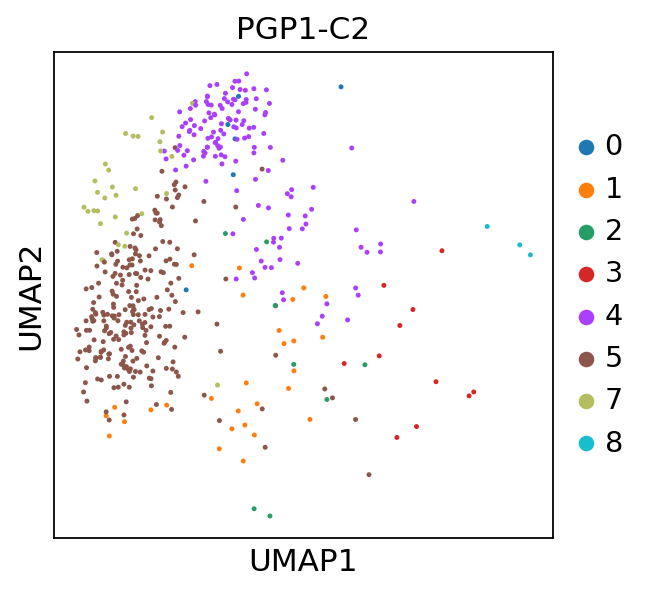

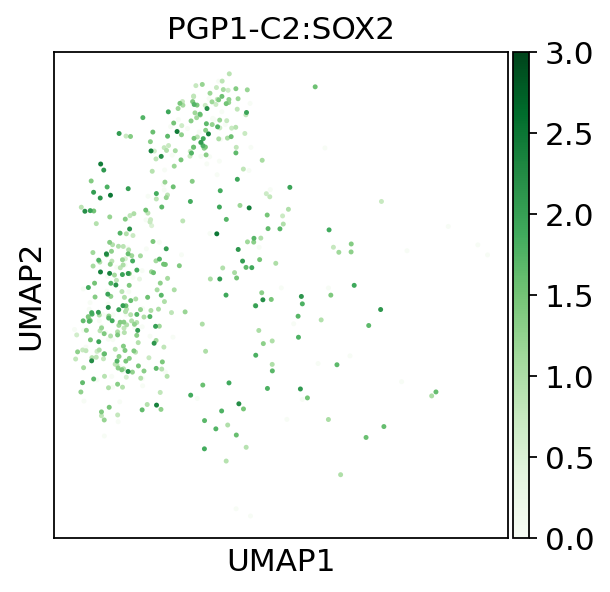

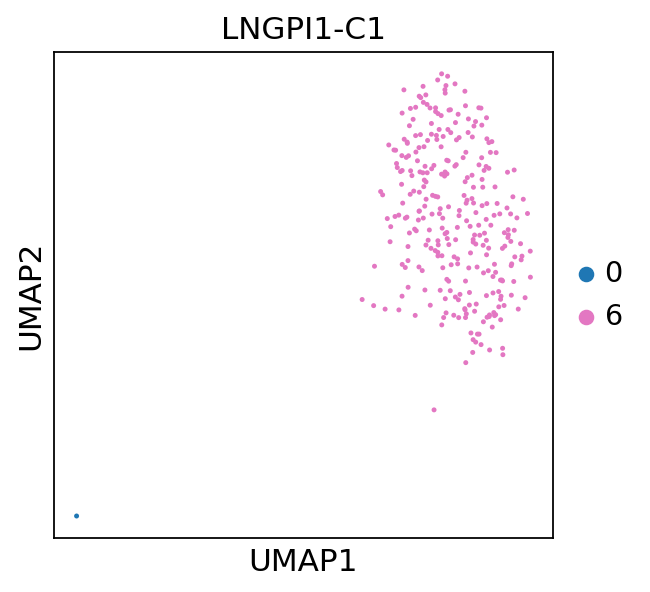

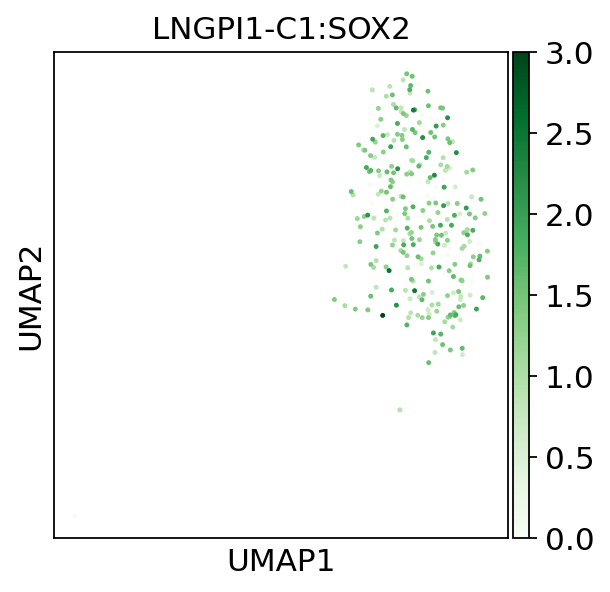

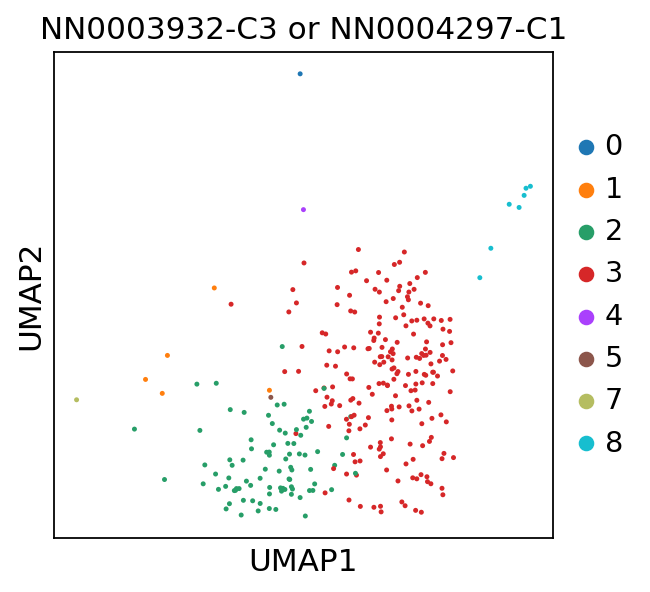

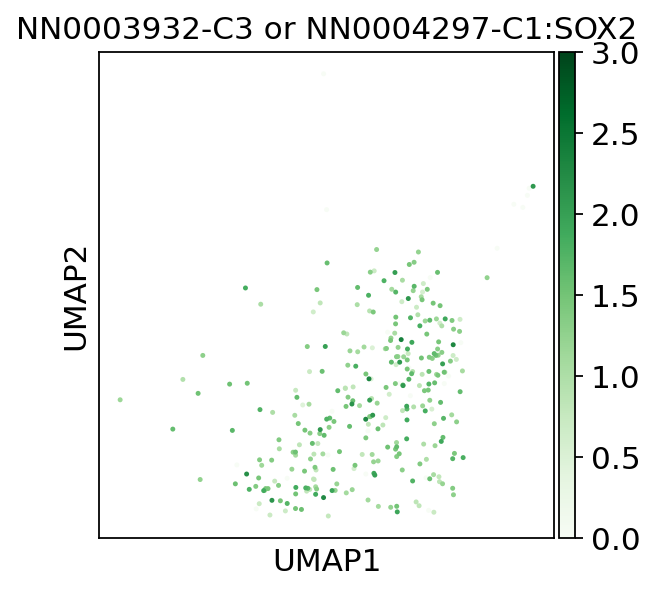

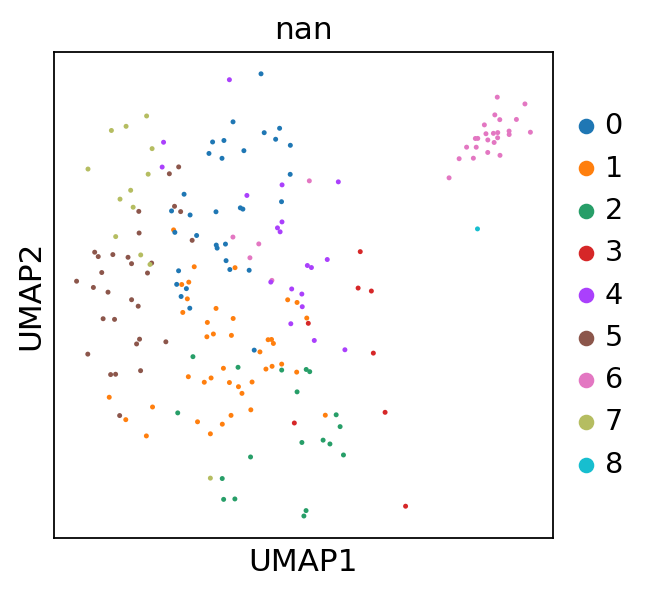

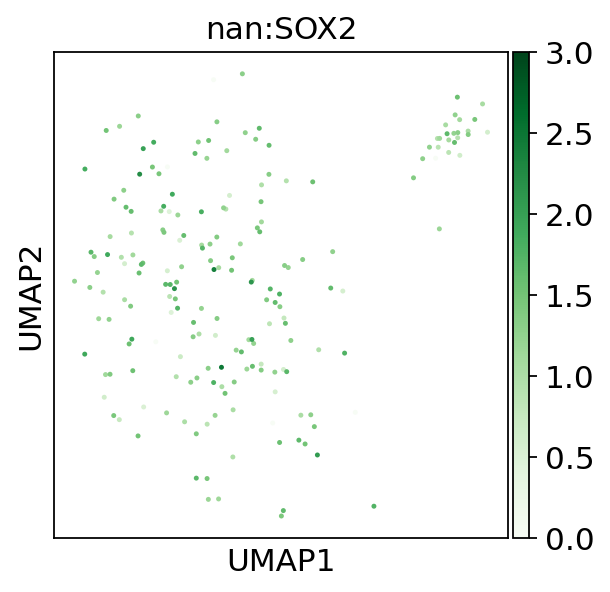

In [0]:
for i in labels:
  ax_title=i+":SOX2"
  ax = sc.pl.umap(adata[adata.obs["donor_label"] == i], color="leiden", color_map="Blues", title=i, size=20)
  sc.pl.umap(
    adata[adata.obs["donor_label"] == i],
    size=20,
    color=["SOX2"],
    color_map="Greens",
    vmax=3,
    title=ax_title,
    ax = ax
  )
